In [26]:
import sys
import os

sys.path.append(os.path.join(os.getcwd(), "src"))

import matplotlib.pyplot as plt
import seaborn as sns
from qiskit import transpile
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import ( ASAPScheduleAnalysis, UnitarySynthesis, BasisTranslator, Optimize1qGatesDecomposition, SabreLayout)
from qiskit.transpiler import InstructionDurations
from qiskit.circuit import Delay
from qiskit.quantum_info import hellinger_fidelity, Statevector
from qiskit.visualization import plot_histogram

# from qiskit.transpiler import Target as target
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit_ibm_runtime.fake_provider.backends import FakeTorontoV2

from DecoherenceWatchdogPass import (
    DecoherenceWatchdog,
    deflate_circuit,
    create_benchmark_circuit,
    post_select_results,
    get_5bit_probs_for_post_selected,
    expand_ideal_to_5bit,
    expand_to_5bit_with_herald_0,
    normalize_counts,
)

%matplotlib inline

In [27]:
sns.set_style("whitegrid")

In [3]:
print("\n1. Setting up simulation environment...")
backend = FakeTorontoV2()
noise_model = NoiseModel.from_backend(backend)
target = backend.target


1. Setting up simulation environment...


In [4]:
ideal_sim = AerSimulator()
noisy_sim = AerSimulator(noise_model=noise_model)

In [5]:
shots = 8192
benchmark_circuit = create_benchmark_circuit()
print(f"   Benchmark circuit '{benchmark_circuit.name}' created.")
print(f"   Using backend '{backend.name}' for noise and transpilation properties.")

   Benchmark circuit 'GHZ_Benchmark_Circuit' created.
   Using backend 'fake_toronto' for noise and transpilation properties.


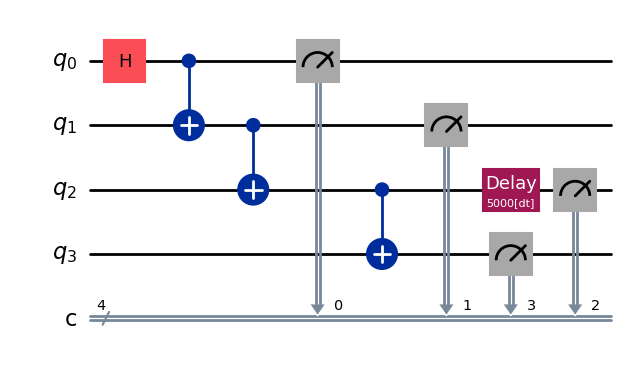

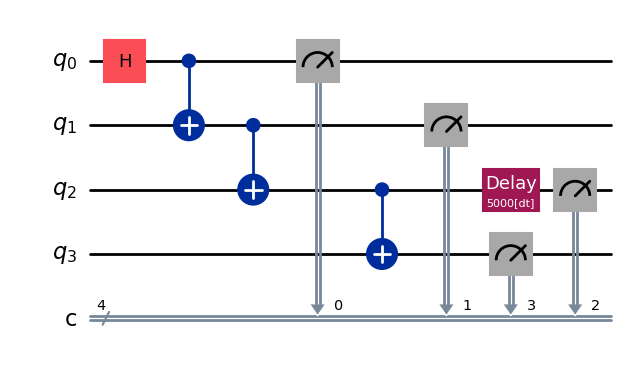

In [6]:
benchmark_circuit.draw(output="mpl")


A. Calculating ideal noise-free reference...
   Ideal distribution calculated with 2 basis states


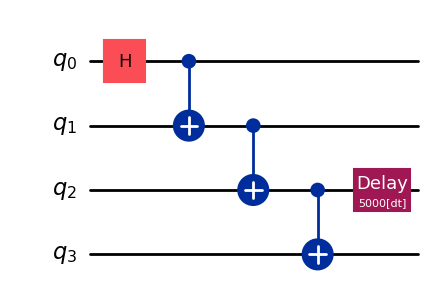

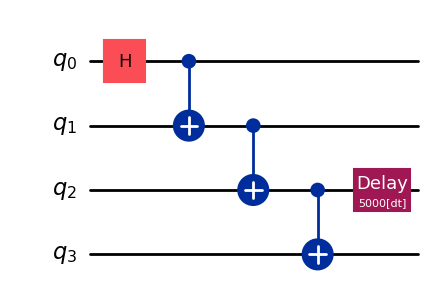

In [7]:
# A. Calculate the ideal, noise-free result for fidelity comparison
print("\nA. Calculating ideal noise-free reference...")
ideal_circuit = benchmark_circuit.copy()
ideal_circuit.remove_final_measurements(inplace=True)
ideal_state = Statevector(ideal_circuit)
ideal_distribution = ideal_state.probabilities_dict()
print(f"   Ideal distribution calculated with {len(ideal_distribution)} basis states")

ideal_circuit.draw(output="mpl")


B. Running Baseline (optimization_level=3)...


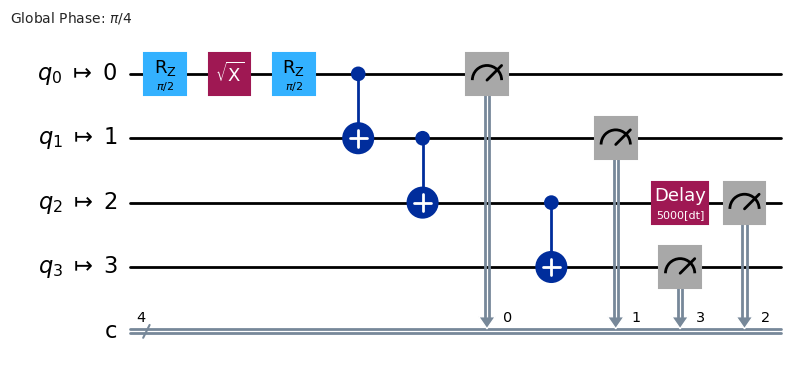

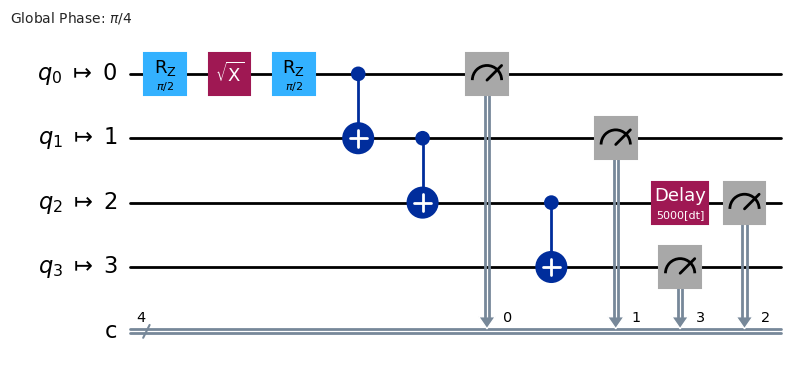

In [8]:
# B. Run the Baseline: Qiskit's best generic optimization
print("\nB. Running Baseline (optimization_level=3)...")
baseline_circuit = transpile(benchmark_circuit, backend, optimization_level=0)
baseline_circuit.draw(output="mpl")

   [Pipeline] Baseline circuit deflated to 4 qubits


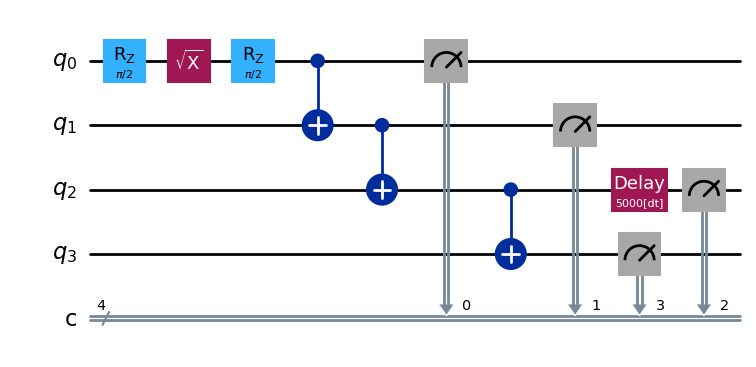

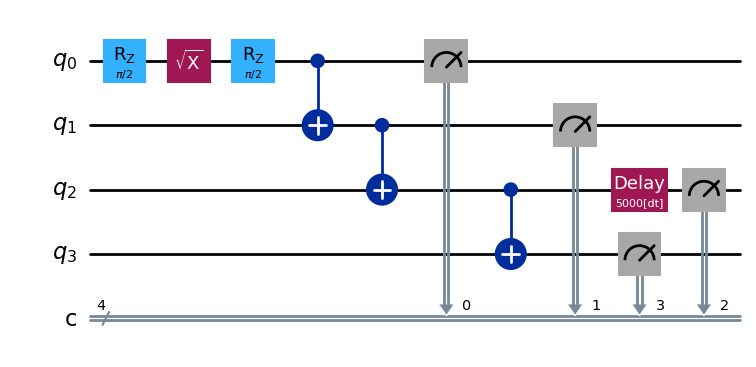

In [9]:
# Deflate the baseline circuit to remove unused qubits
baseline_circuit = deflate_circuit(baseline_circuit)
print(f"   [Pipeline] Baseline circuit deflated to {baseline_circuit.num_qubits} qubits")
baseline_circuit.draw(output="mpl")

In [10]:
sim_noise = AerSimulator.from_backend(backend)
baseline_result = sim_noise.run(baseline_circuit, shots=shots).result()
baseline_counts = baseline_result.get_counts()
baseline_fidelity = hellinger_fidelity(ideal_distribution, baseline_counts)
print(f"   Baseline Fidelity: {baseline_fidelity:.4f}")

   Baseline Fidelity: 0.7472



4. Running Our Custom 'Decoherence Watchdog' Pass...
   [Pipeline] Building a professional-grade transpilation pipeline...
   [Pipeline] Stage 1: Layout and Basis Translation...


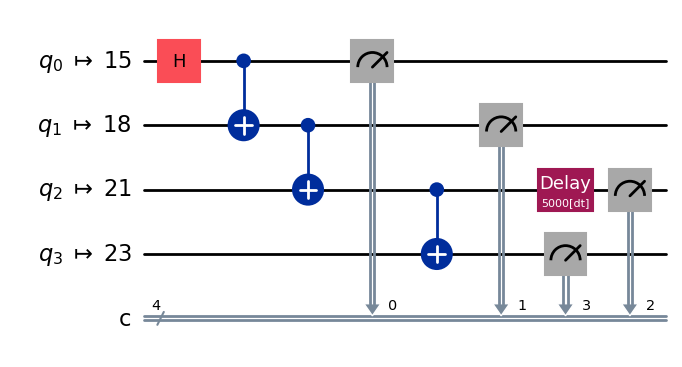

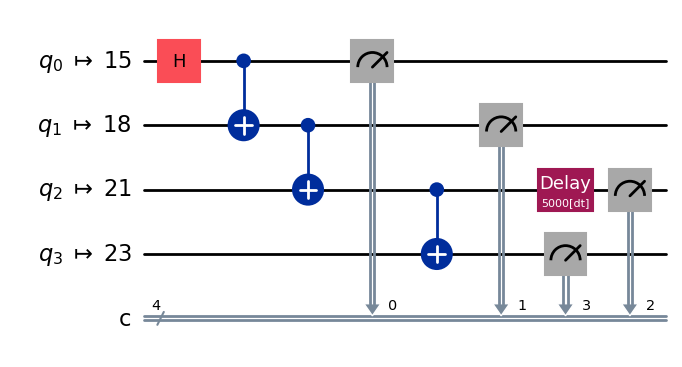

In [14]:
# 4. Run Our Custom Solution
print("\n4. Running Our Custom 'Decoherence Watchdog' Pass...")
print("   [Pipeline] Building a professional-grade transpilation pipeline...")

# Build a structured PassManager following Qiskit documentation

# Stage 1: Layout and basis translation
print("   [Pipeline] Stage 1: Layout and Basis Translation...")
layout_pm = PassManager([
    SabreLayout(coupling_map=backend.coupling_map, max_iterations=4, seed=42),
    UnitarySynthesis(basis_gates=backend.target.operation_names),
])
laid_out_circuit = layout_pm.run(benchmark_circuit)

laid_out_circuit.draw(output="mpl")

In [15]:
# Create comprehensive InstructionDurations that should work with most backends
try:
    # Try to get durations from backend first
    base_durations = InstructionDurations.from_backend(backend)
    
    # Add/update all missing durations to ensure comprehensive coverage
    additional_durations = [
        ('h', None, 35),        # Hadamard gate duration
        ('x', None, 35),        # X gate duration
        ('reset', None, 840),   # Reset duration
        ('delay', None, 1),     # Delay duration (per dt)
        ('barrier', None, 0),   # Barrier has no duration
        ('id', None, 0),        # Identity gate has no duration
        ('rz', None, 0),        # Virtual Z rotation
        ('sx', None, 35),       # SX gate duration
    ]
    
    # Add durations for all qubits in the backend to avoid missing duration errors
    comprehensive_durations = []
    for name, qubits, duration in additional_durations:
        if qubits is None:
            for qubit_idx in range(backend.num_qubits):
                comprehensive_durations.append((name, [qubit_idx], duration))
            # Also add the general version
            comprehensive_durations.append((name, None, duration))
        else:
            comprehensive_durations.append((name, qubits, duration))
    
    base_durations.update(comprehensive_durations)
    durations = base_durations
    print("   [Pipeline] Enhanced backend durations with comprehensive fallbacks")
    
except Exception as e:
    print(f"   [Pipeline] Backend duration extraction failed: {e}")
    
    # Create complete fallback durations for all qubits
    fallback_durations = []
    basic_gates = [
        ('cx', 160),    # CNOT duration
        ('x', 35),      # X gate duration
        ('h', 35),      # Hadamard gate duration  
        ('measure', 5440), # Measurement duration
        ('reset', 840), # Reset duration
        ('delay', 1),   # Delay duration (per dt)
        ('barrier', 0), # Barrier has no duration
        ('id', 0),      # Identity gate has no duration
        ('rz', 0),      # Virtual Z rotation
        ('sx', 35),     # SX gate duration
    ]
    
    # Add durations for every qubit to avoid missing duration errors
    for gate_name, gate_duration in basic_gates:
        # Add general version
        fallback_durations.append((gate_name, None, gate_duration))
        # Add per-qubit versions
        for qubit_idx in range(backend.num_qubits):
            fallback_durations.append((gate_name, [qubit_idx], gate_duration))
    
    # For two-qubit gates, add all qubit pairs from coupling map
    if hasattr(backend, 'coupling_map') and backend.coupling_map:
        for edge in backend.coupling_map.get_edges():
            fallback_durations.append(('cx', list(edge), 160))
    
    durations = InstructionDurations(
        fallback_durations, 
        dt=backend.dt if hasattr(backend, 'dt') else 0.1/1e9
    )
    print("   [Pipeline] Created comprehensive fallback instruction durations")

   [Pipeline] Enhanced backend durations with comprehensive fallbacks


In [9]:
# 3. Standard Noisy Run (Qiskit's Default Optimization)
print("\n3. Running Standard Noisy Simulation (opt_level=3)...")
std_t_qc = transpile(qc_bench, backend=backend, optimization_level=3)
std_result = noisy_sim.run(std_t_qc, shots=shots).result()
std_counts = std_result.get_counts()


3. Running Standard Noisy Simulation (opt_level=3)...


[WatchdogPass] Analyzing circuit for vulnerabilities using scheduling information...
[WatchdogPass] Found most vulnerable idle period on qubit 18 with vulnerability score: 0.0616 (duration: 33280 dt)
[WatchdogPass] Gadget sequence inserted on data qubit 18 using ancilla qubit 27.
   [Pipeline] Successfully used ASAPScheduleAnalysis for idle time detection


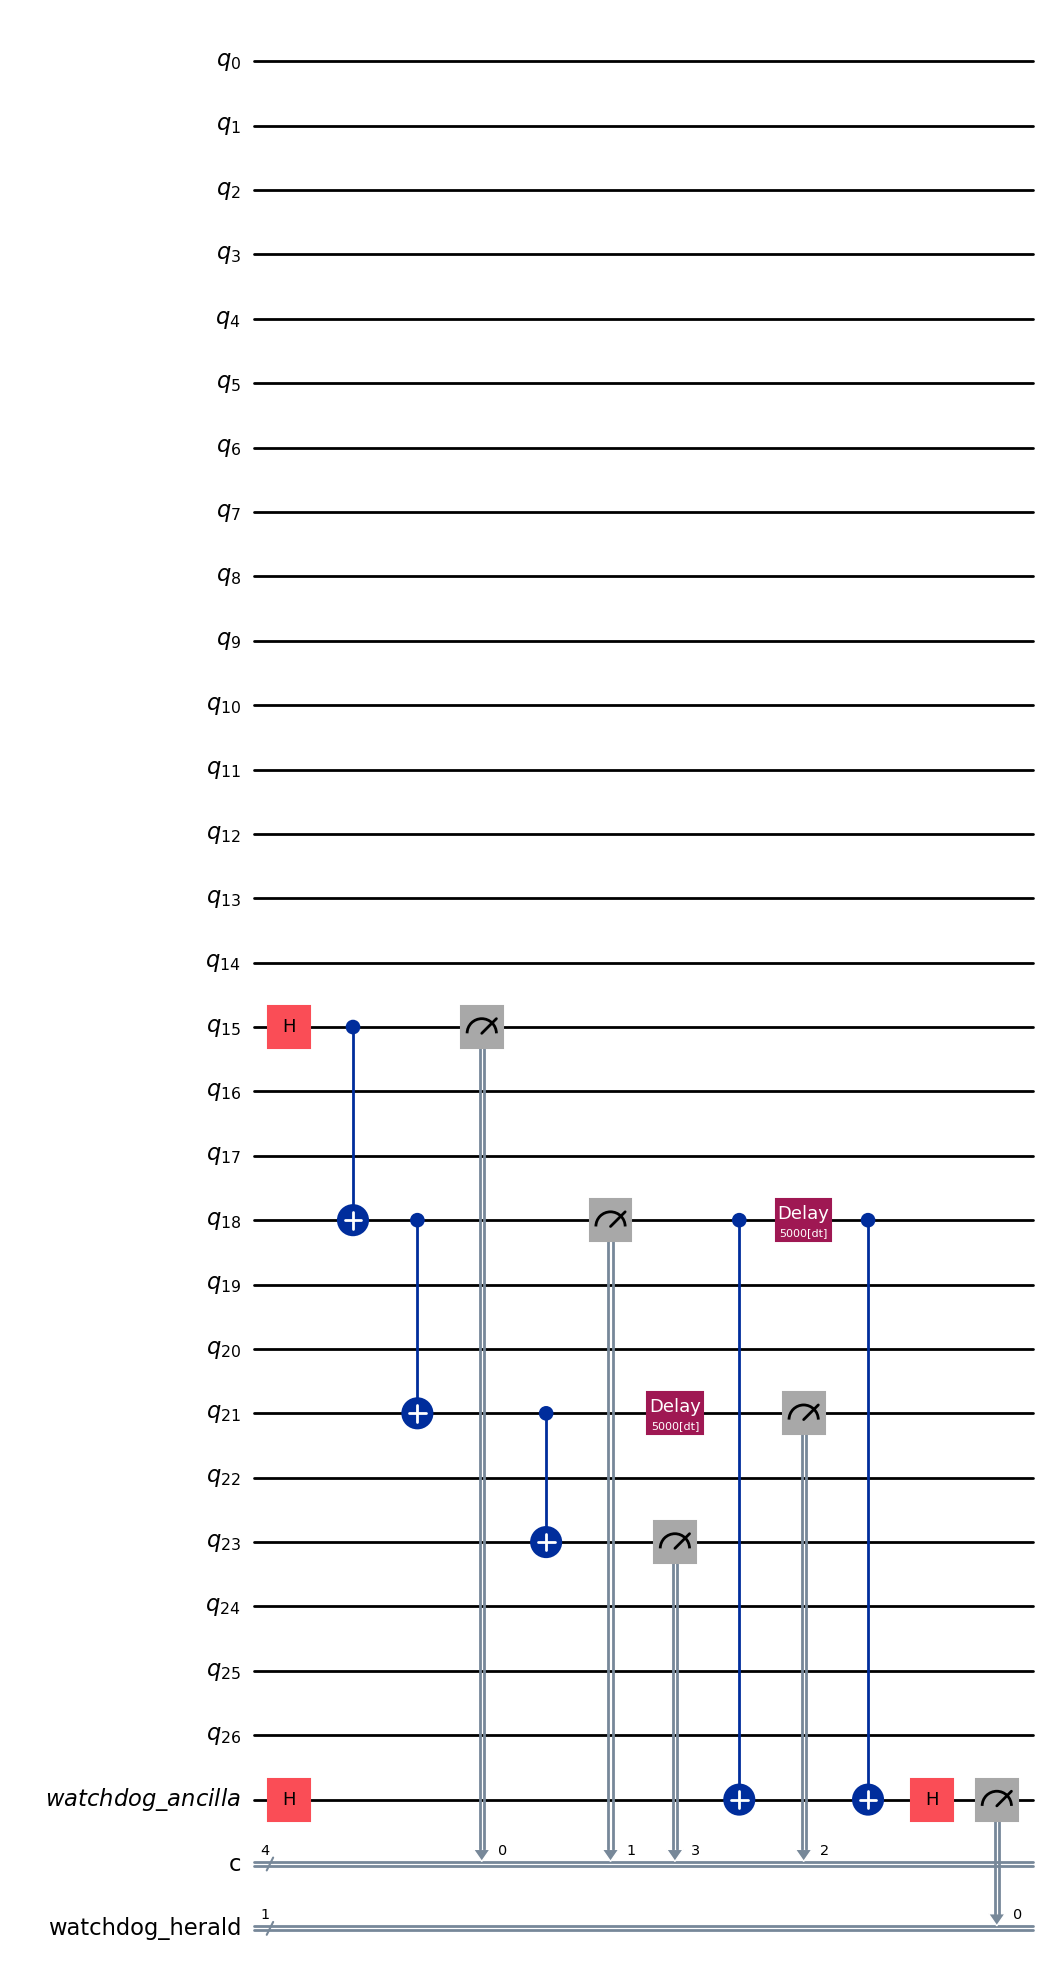

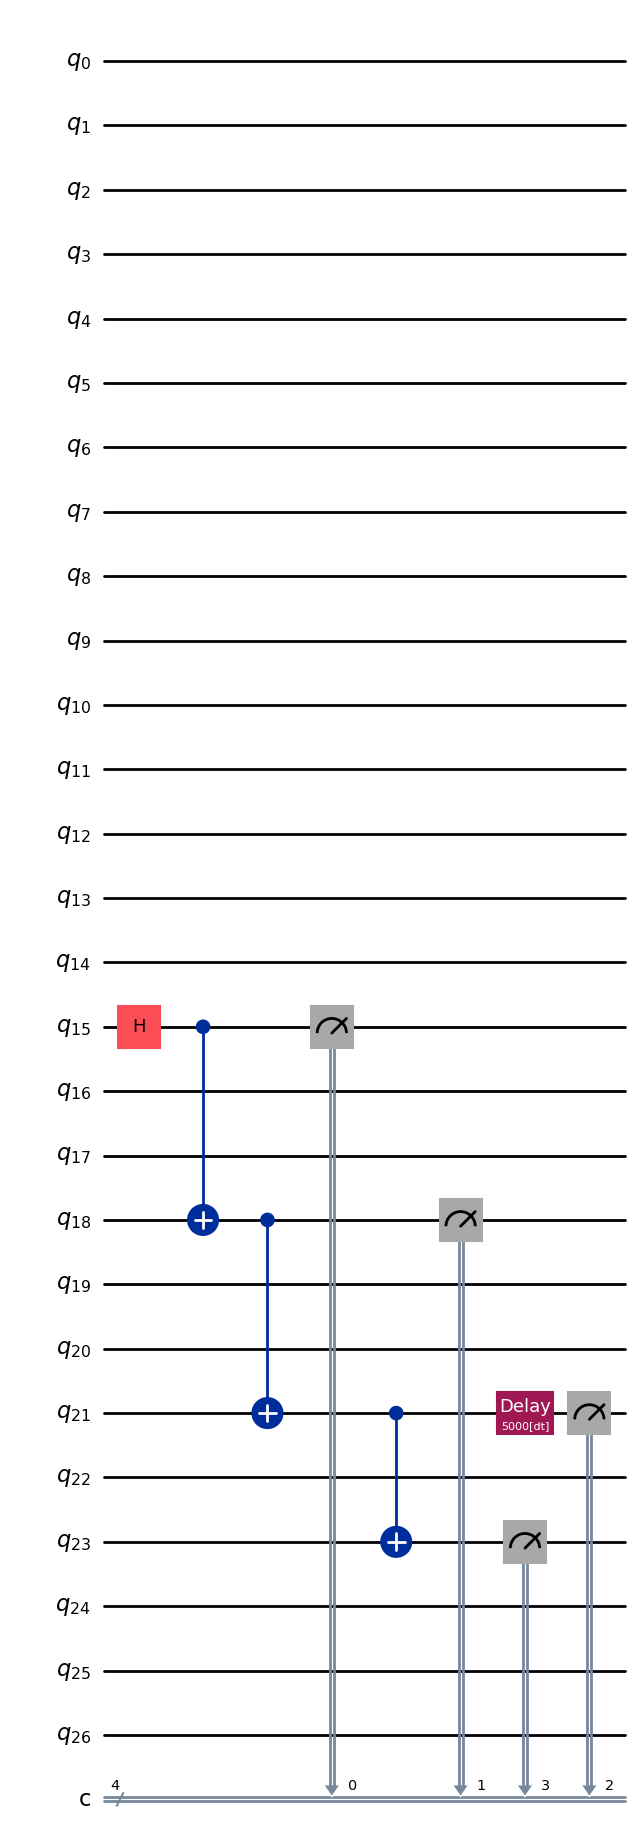

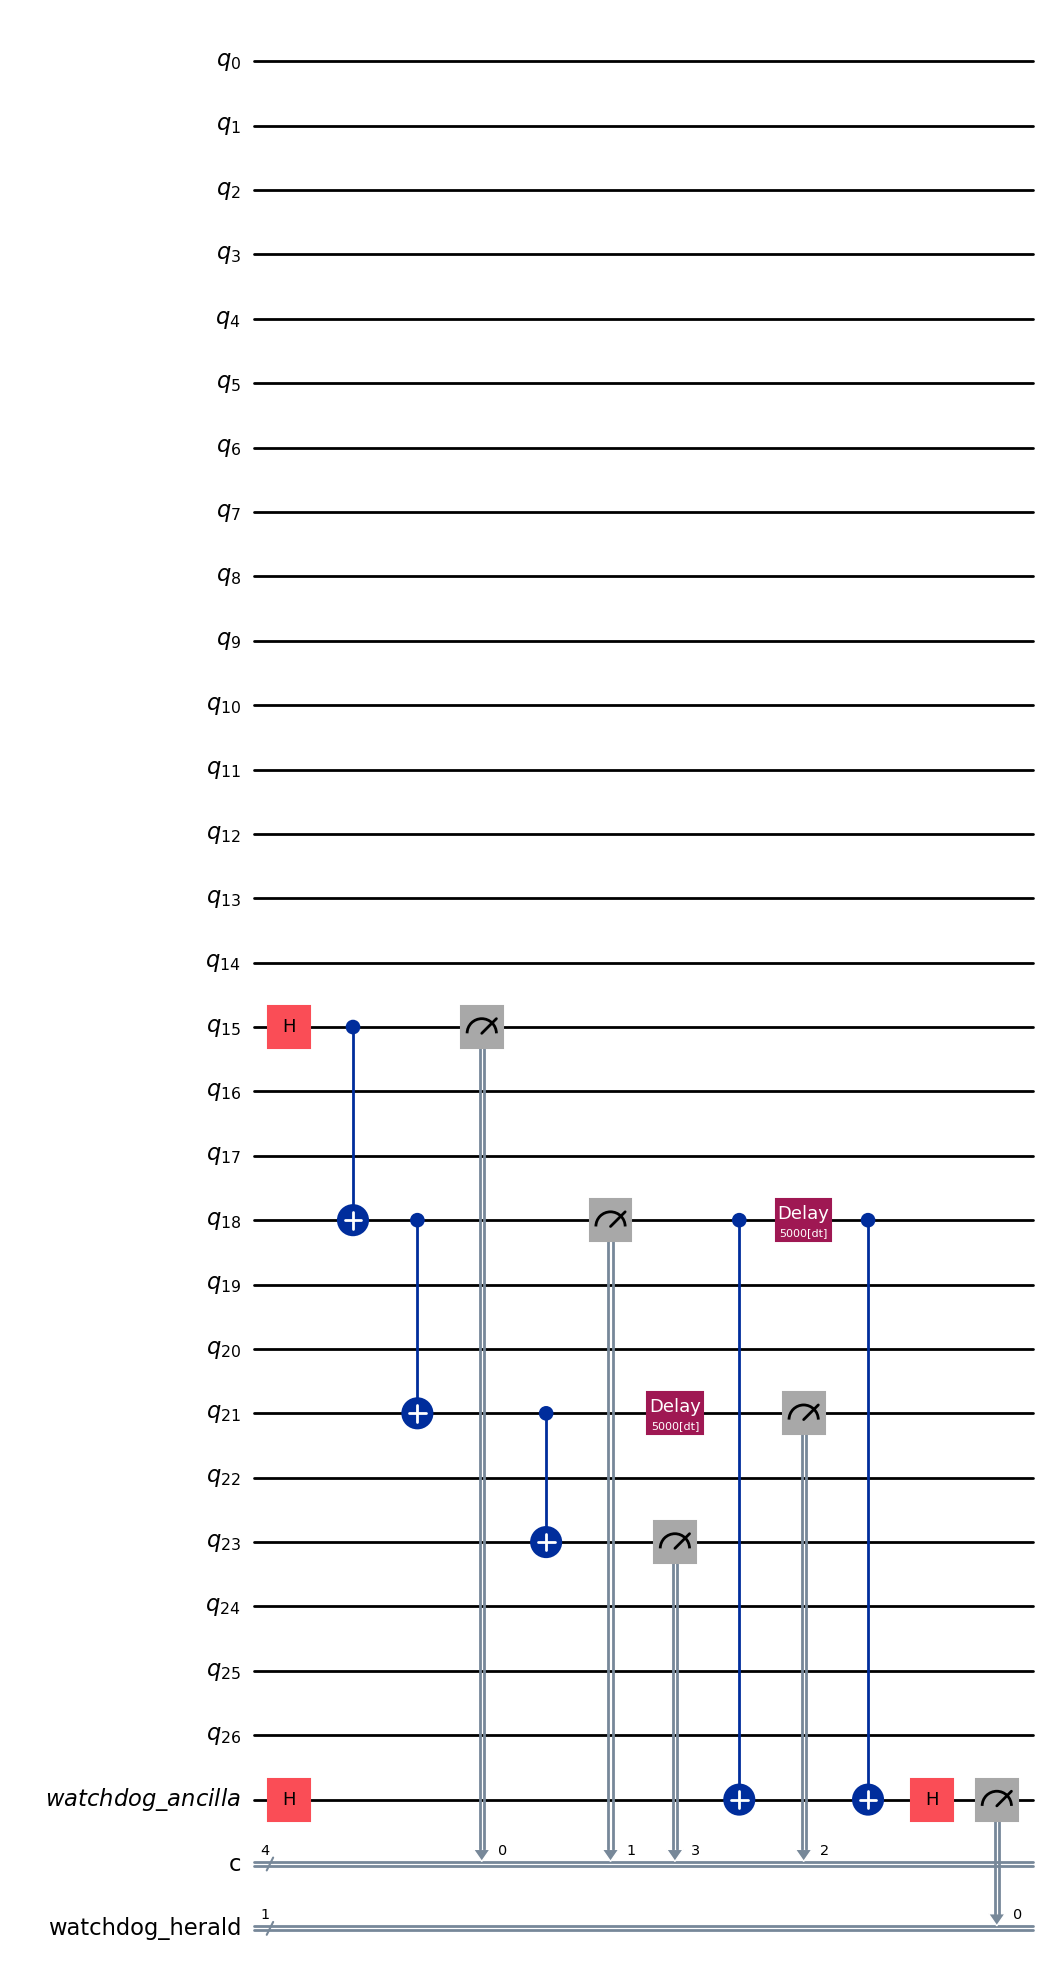

In [18]:
# Try to run with scheduling analysis, but fall back if it fails
try:
    # First run scheduling analysis to get timing information
    schedule_analysis_pm = PassManager([ASAPScheduleAnalysis(durations)])
    temp_circuit = schedule_analysis_pm.run(laid_out_circuit)

    temp_circuit.draw(output="mpl")
    
    # Extract the scheduling information from the property set
    start_times = schedule_analysis_pm.property_set.get('node_start_time', {})
    
    # Now run the watchdog pass on the original circuit with the scheduling info
    watchdog_pass = DecoherenceWatchdog(backend, durations)
    # Pass the scheduling information to the watchdog pass
    if hasattr(watchdog_pass, '_start_times'):
        watchdog_pass._start_times = start_times
    
    watchdog_pm = PassManager([watchdog_pass])
    watchdog_inserted_circuit = watchdog_pm.run(laid_out_circuit)
    print("   [Pipeline] Successfully used ASAPScheduleAnalysis for idle time detection")
except Exception as e:
    print(f"   [Pipeline] ASAPScheduleAnalysis failed: {e}")
    print("   [Pipeline] Falling back to basic watchdog insertion without scheduling")
    
    # Fallback: run without scheduling analysis
    watchdog_pm = PassManager([
        DecoherenceWatchdog(backend, durations),
    ])
    watchdog_inserted_circuit = watchdog_pm.run(laid_out_circuit)

watchdog_inserted_circuit.draw(output="mpl")

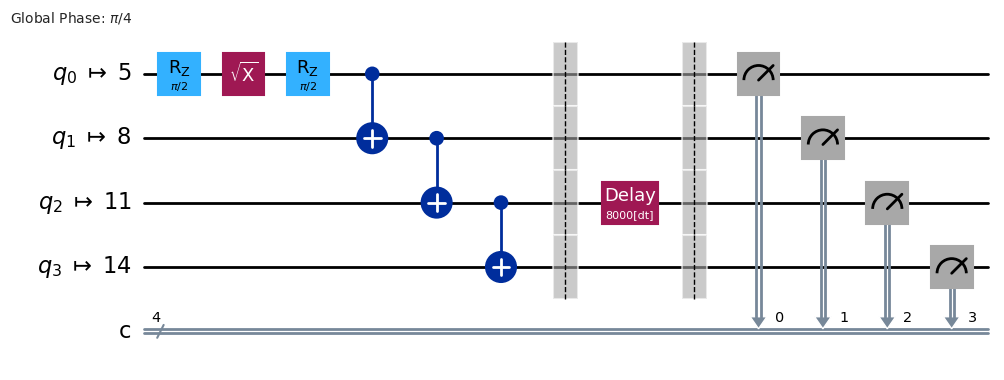

In [10]:
std_t_qc.draw(output="mpl")

   [Pipeline] Stage 3: Final Optimization...


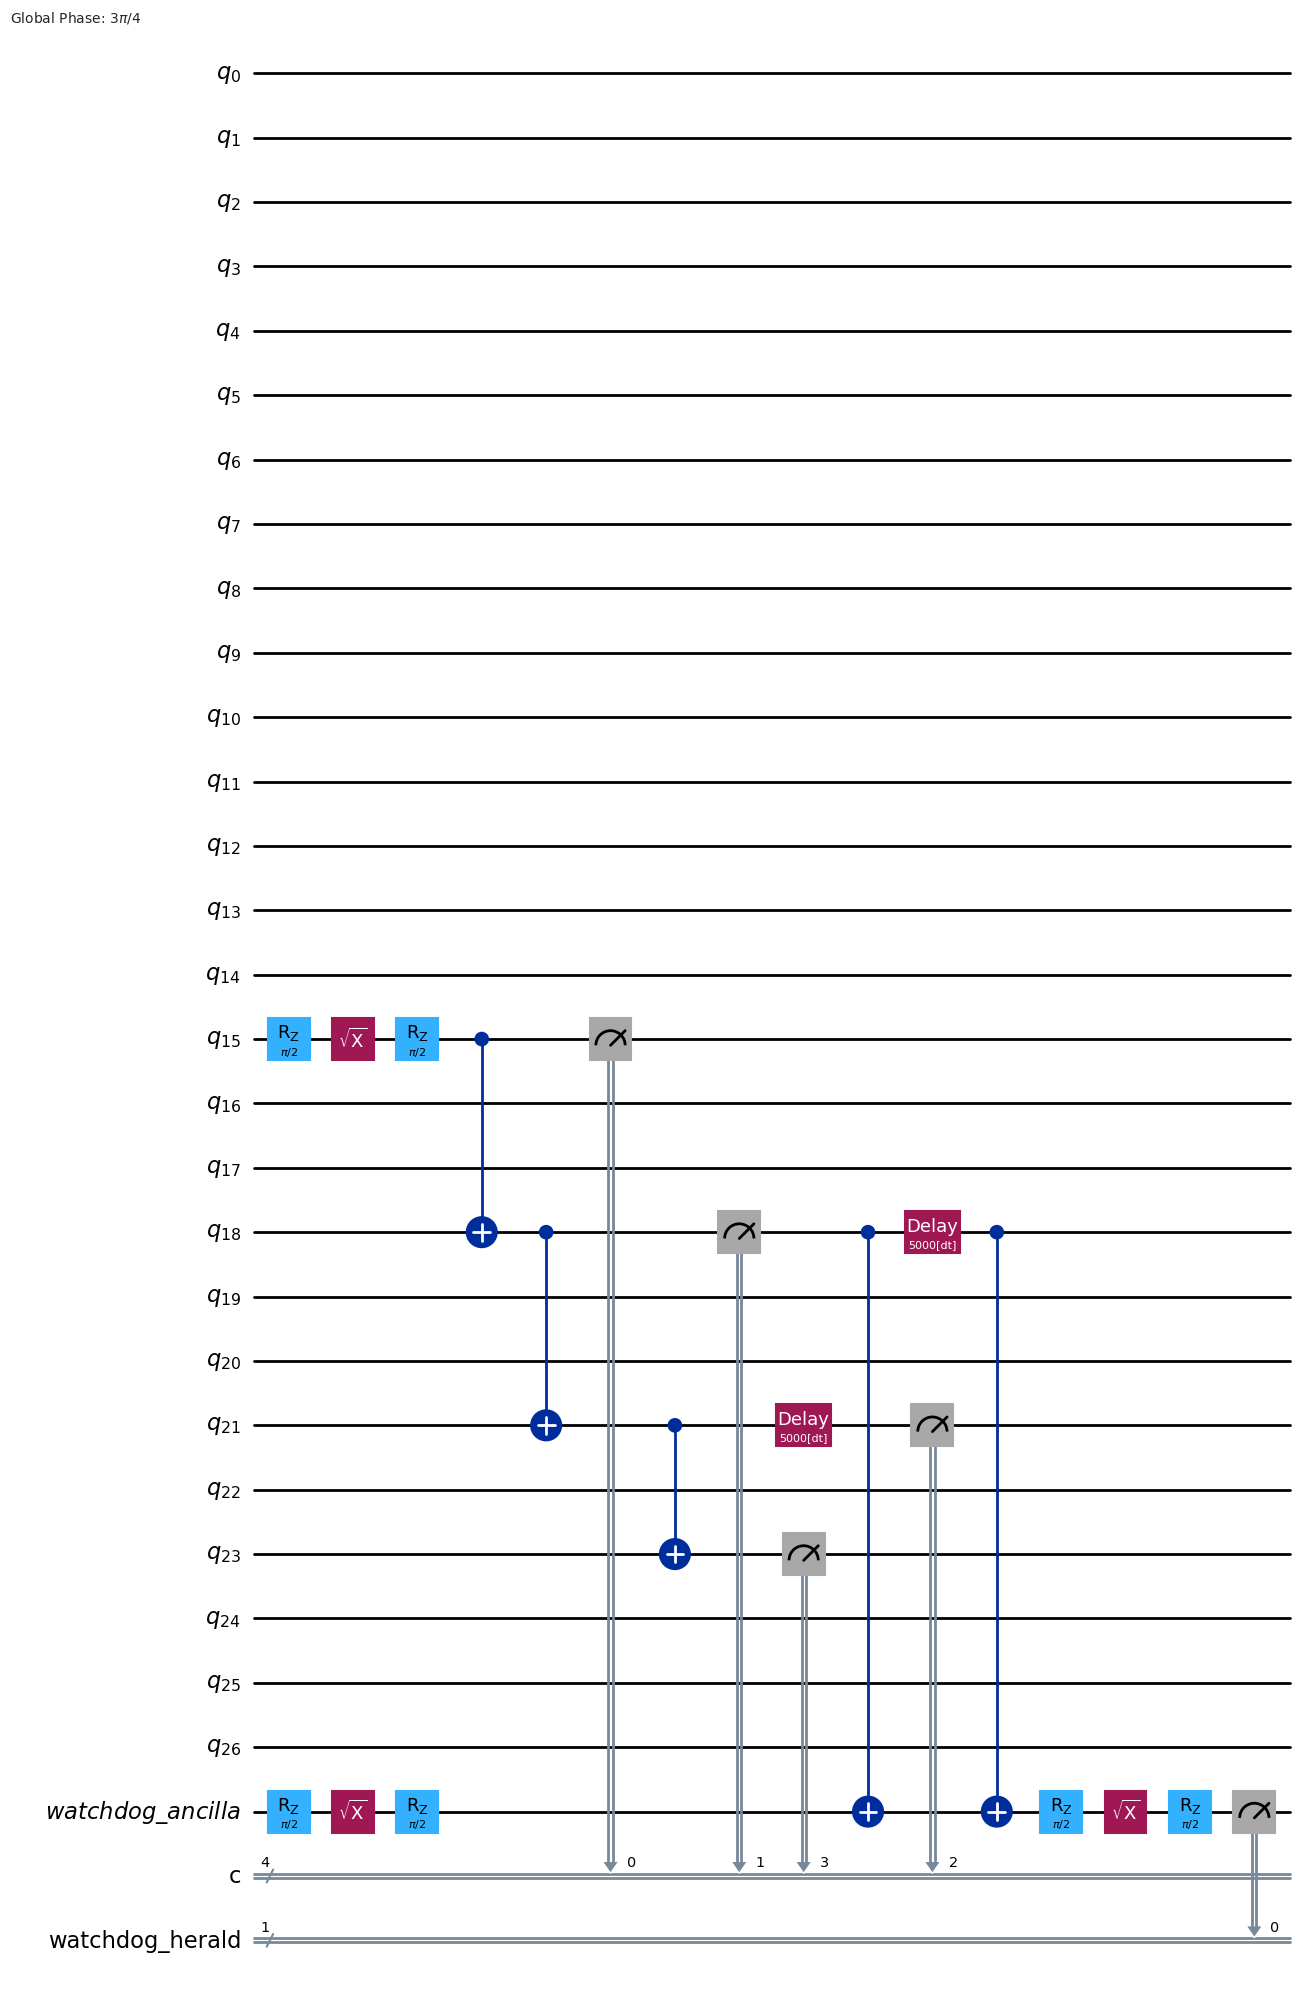

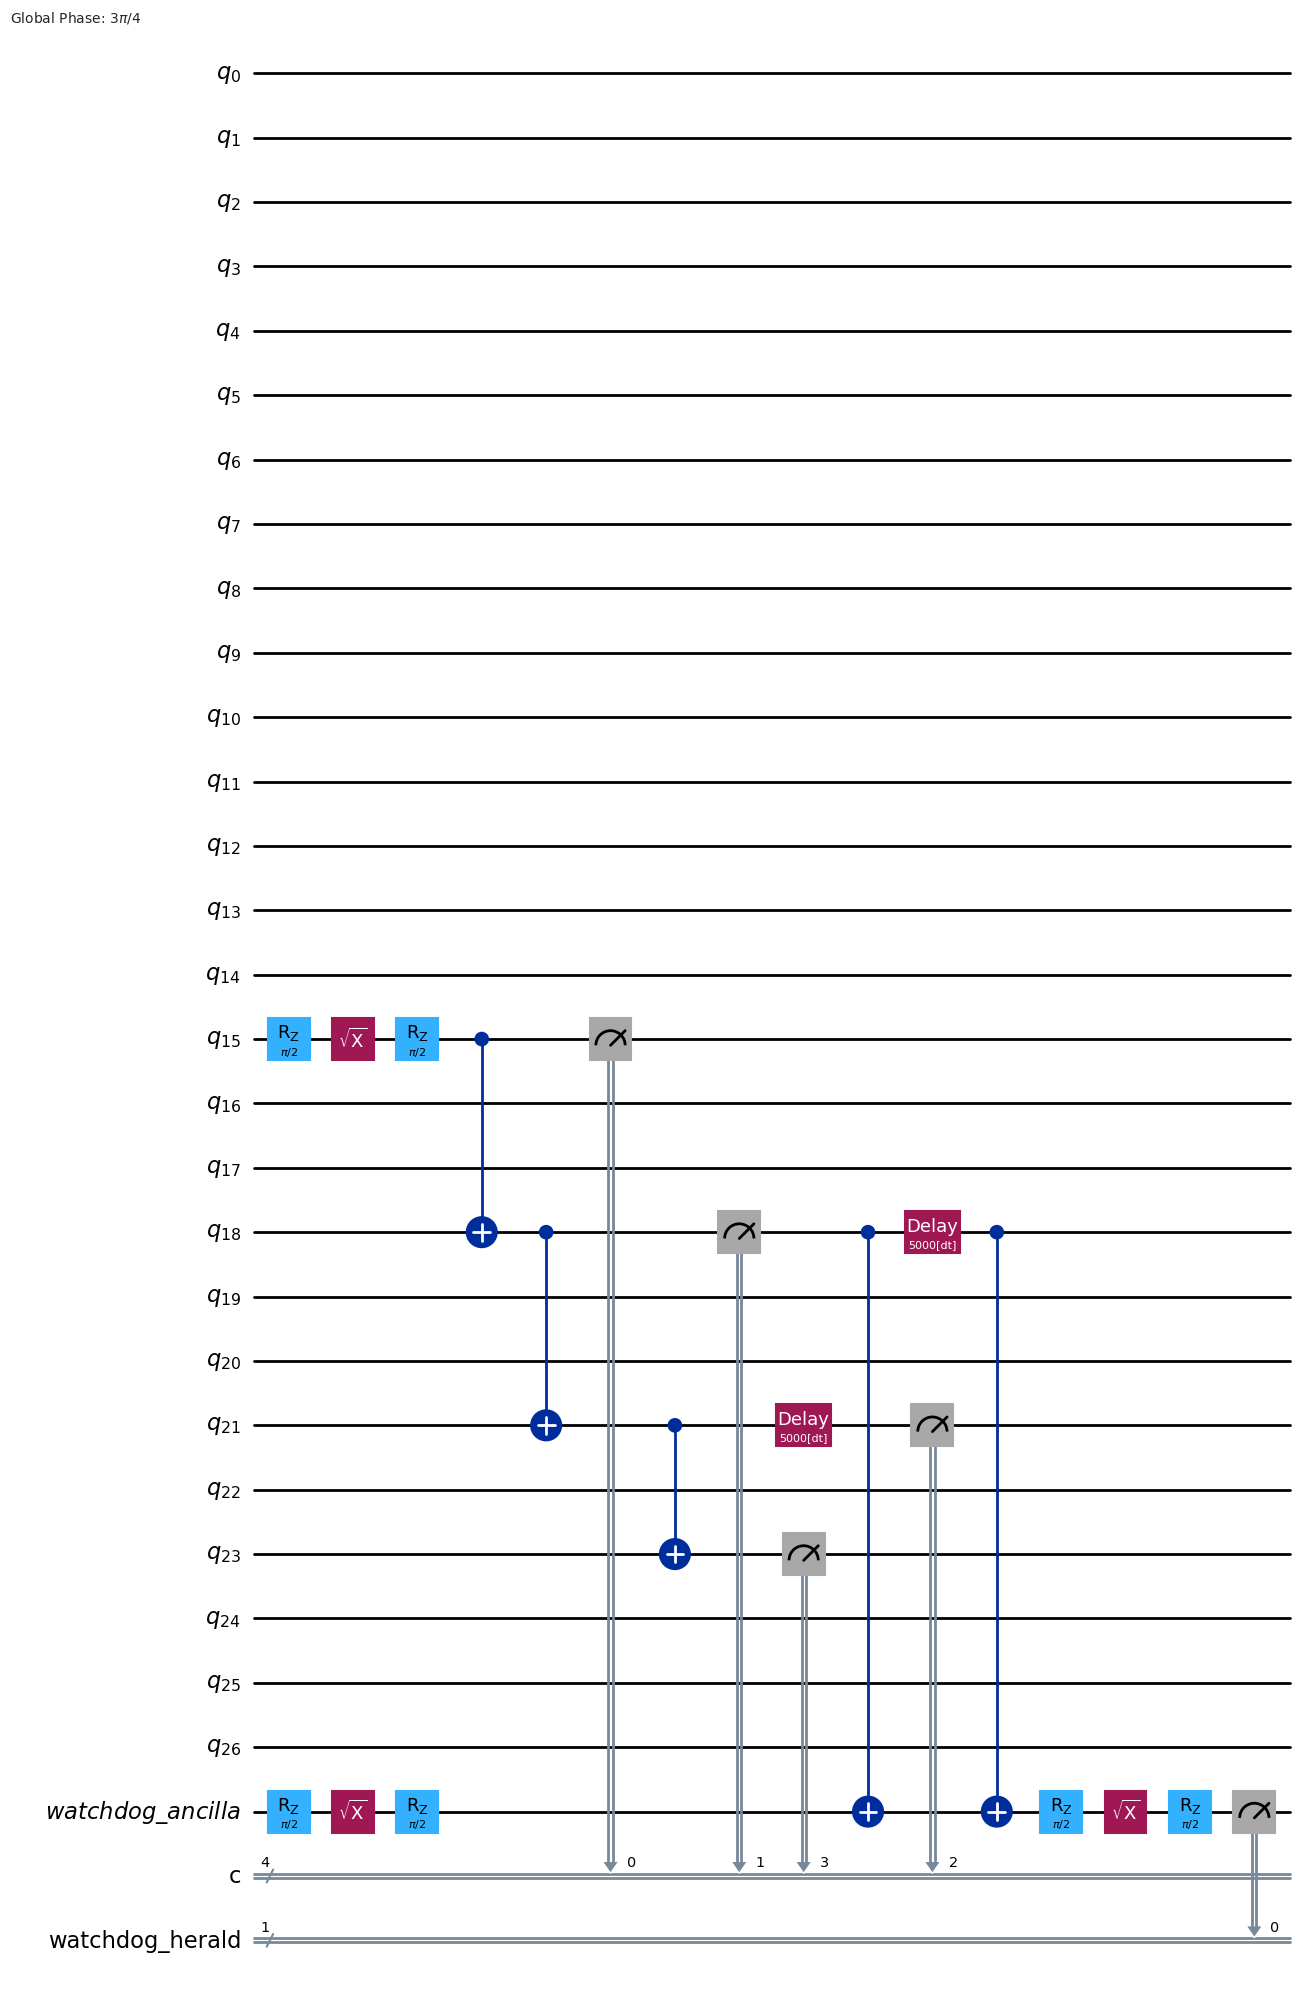

In [19]:
# Stage 3: Final optimization 
print("   [Pipeline] Stage 3: Final Optimization...")
final_opt_pm = PassManager([
    Optimize1qGatesDecomposition(basis=list(backend.target.operation_names)),
])
watchdog_circuit = final_opt_pm.run(watchdog_inserted_circuit)
watchdog_circuit.draw(output="mpl")

   [Pipeline] Final deflation to remove unused qubits...
   [Pipeline] Final circuit deflated to 5 qubits and 5 classical bits


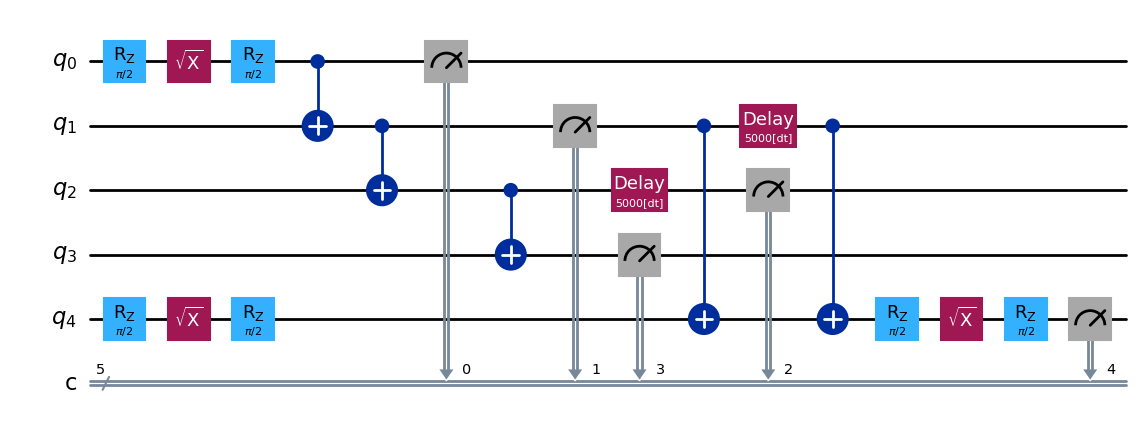

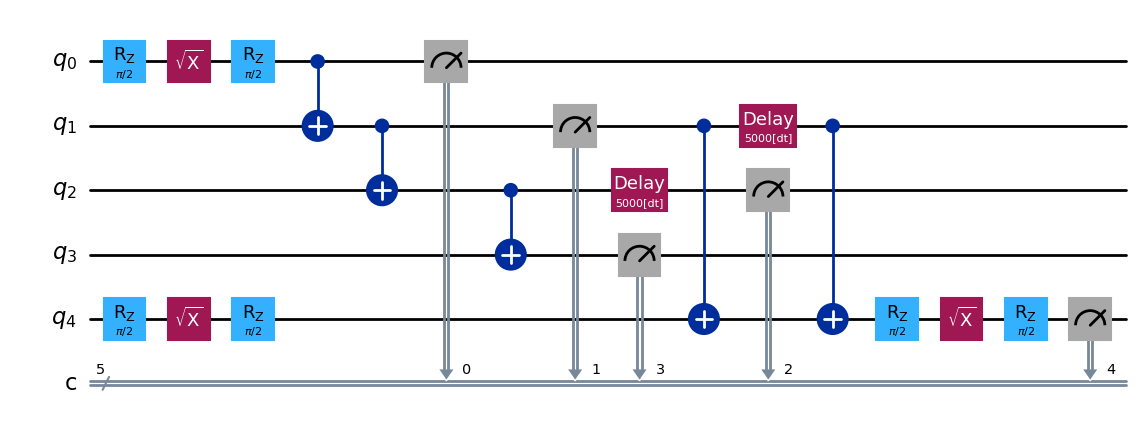

In [20]:
# Final step: Deflate the circuit to remove unused qubits
print("   [Pipeline] Final deflation to remove unused qubits...")
final_watchdog_circuit = deflate_circuit(watchdog_circuit)
print(f"   [Pipeline] Final circuit deflated to {final_watchdog_circuit.num_qubits} qubits and {final_watchdog_circuit.num_clbits} classical bits")
final_watchdog_circuit.draw(output="mpl")

In [21]:
# Run the final circuit
watchdog_result = sim_noise.run(final_watchdog_circuit, shots=shots, memory=True).result()
watchdog_counts = watchdog_result.get_counts()
memory = watchdog_result.get_memory()

print(f"   Sample watchdog outcomes (first 5):")
sample_outcomes = list(watchdog_counts.keys())[:5]
for outcome in sample_outcomes:
    print(f"     {outcome} -> {watchdog_counts[outcome]} counts")


   Sample watchdog outcomes (first 5):
     11010 -> 2 counts
     00101 -> 22 counts
     10001 -> 37 counts
     01001 -> 18 counts
     00111 -> 127 counts


In [28]:
# D. Post-process watchdog results
print("\nD. Post-processing watchdog results...")

num_data_clbits = benchmark_circuit.num_clbits
herald_bit_index = 0  # Leftmost bit in Qiskit's little-endian format

# Check if we have a herald bit (more classical bits than original)


if final_watchdog_circuit.num_clbits > num_data_clbits:
    print("   Performing post-selection on herald bit...")
    watchdog_ps_counts, discard_fraction = post_select_results(watchdog_counts, herald_bit_index, num_data_clbits)
    
    # For proper fidelity comparison, we need to expand ideal distribution to 5-bit
    ideal_5bit_distribution = expand_ideal_to_5bit(ideal_distribution)
    
    # Raw watchdog fidelity: compare expanded ideal with raw watchdog (both 5-bit)
    watchdog_fidelity = hellinger_fidelity(ideal_5bit_distribution, watchdog_counts)
    
    # Post-selected fidelity: compare 4-bit ideal with post-selected results (both 4-bit)
    watchdog_ps_fidelity = hellinger_fidelity(ideal_distribution, watchdog_ps_counts)
    
    print(f"   Raw Watchdog Fidelity: {watchdog_fidelity:.4f}")
    print(f"   Post-Selected Fidelity: {watchdog_ps_fidelity:.4f}")
    print(f"   Shot Discard Fraction: {discard_fraction:.2%}")
else:
    print("   No herald bit found - watchdog pass did not modify circuit")
    watchdog_ps_counts = watchdog_counts
    discard_fraction = 0.0
    watchdog_fidelity = hellinger_fidelity(ideal_distribution, watchdog_counts)
    watchdog_ps_fidelity = watchdog_fidelity
    discard_fraction = 0.0
    watchdog_fidelity = hellinger_fidelity(ideal_distribution, watchdog_counts)
    watchdog_ps_fidelity = watchdog_fidelity


D. Post-processing watchdog results...
   Performing post-selection on herald bit...
   Raw Watchdog Fidelity: 0.6754
   Post-Selected Fidelity: 0.7517
   Shot Discard Fraction: 10.14%


In [29]:
# E. Compare Results
print("\n--- Final Benchmark Results ---")
print(f"Ideal Reference:              Perfect (1.0000)")
print(f"Baseline Fidelity:            {baseline_fidelity:.4f}")
print(f"Watchdog Raw Fidelity:        {watchdog_fidelity:.4f}")
print(f"Watchdog Post-Selected:       {watchdog_ps_fidelity:.4f}")
print(f"Improvement (PS vs Baseline): {((watchdog_ps_fidelity - baseline_fidelity) / baseline_fidelity) * 100:+.2f}%")
print(f"Shot Discard Rate:            {discard_fraction:.2%}")

# F. Calculate GHZ state probabilities for detailed analysis
print("\n--- GHZ State Analysis ---")
print("(GHZ analysis will be calculated from table values after table generation)")


--- Final Benchmark Results ---
Ideal Reference:              Perfect (1.0000)
Baseline Fidelity:            0.7472
Watchdog Raw Fidelity:        0.6754
Watchdog Post-Selected:       0.7517
Improvement (PS vs Baseline): +0.60%
Shot Discard Rate:            10.14%

--- GHZ State Analysis ---
(GHZ analysis will be calculated from table values after table generation)



G. Generating comprehensive comparison plots and analysis...
   Shot statistics:
   - Baseline shots: 8192
   - Watchdog raw shots: 8192
   - Watchdog post-selected shots: 7361
   Results plot saved to 'watchdog_benchmark_results.png'


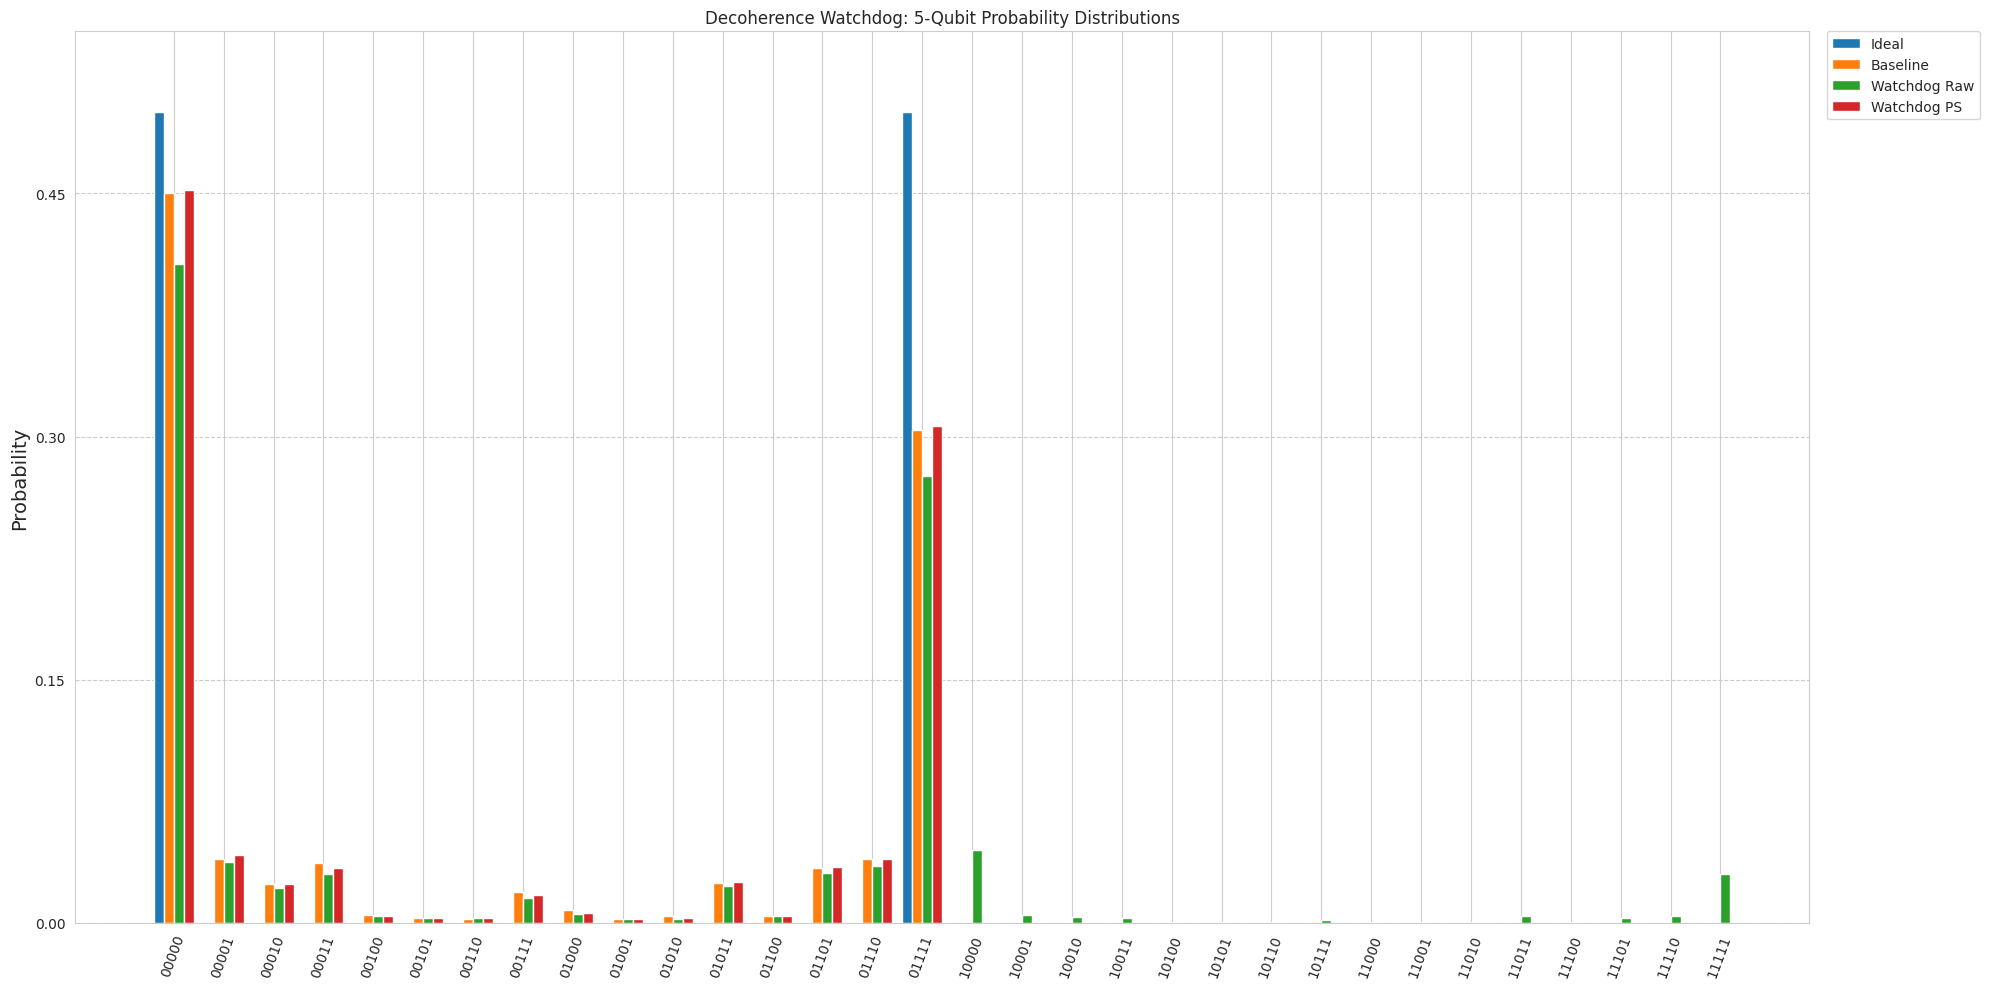

In [30]:
# G. Generate comprehensive visualization and analysis
print("\nG. Generating comprehensive comparison plots and analysis...")



# Create normalized 5-qubit probability distributions for all cases including ideal
ideal_5bit_probs = normalize_counts(expand_to_5bit_with_herald_0(ideal_distribution))
baseline_5bit_probs = normalize_counts(expand_to_5bit_with_herald_0(baseline_counts))

# Handle watchdog data based on whether it has herald bit
if final_watchdog_circuit.num_clbits > num_data_clbits:
    # We have a real watchdog circuit with herald bit
    watchdog_raw_5bit_probs = normalize_counts(watchdog_counts)
    watchdog_ps_5bit_probs = get_5bit_probs_for_post_selected(watchdog_ps_counts, watchdog_counts)
else:
    # Watchdog circuit fell back to standard circuit
    watchdog_raw_5bit_probs = normalize_counts(expand_to_5bit_with_herald_0(watchdog_counts))
    watchdog_ps_5bit_probs = normalize_counts(expand_to_5bit_with_herald_0(watchdog_ps_counts))

# Print shot statistics
print(f"   Shot statistics:")
print(f"   - Baseline shots: {sum(baseline_counts.values())}")
print(f"   - Watchdog raw shots: {sum(watchdog_counts.values())}")
print(f"   - Watchdog post-selected shots: {sum(watchdog_ps_counts.values())}")

# Create comprehensive histogram with all normalized distributions including ideal
# Note: GHZ values will be calculated from table and updated in the final output
legend = [
    f'Ideal',
    f'Baseline', 
    f'Watchdog Raw',
    f'Watchdog PS'
]
hist_data = [ideal_5bit_probs, baseline_5bit_probs, watchdog_raw_5bit_probs, watchdog_ps_5bit_probs]

fig = plot_histogram(hist_data, legend=legend, figsize=(20, 10),
                        title="Decoherence Watchdog: 5-Qubit Probability Distributions",
                        bar_labels=False)

ax = fig.gca()
ax.set_ylabel("Probability")
ax.yaxis.grid(True, linestyle='--')
plt.tight_layout()

fig.savefig("watchdog_benchmark_results.png", dpi=300, bbox_inches='tight')
print("   Results plot saved to 'watchdog_benchmark_results.png'")


In [31]:
# H. Create comprehensive 5-qubit state probability table
print("\n--- Complete 5-Qubit State Probability Distribution ---")

# Prepare all data for the table including ideal
ideal_5bit = expand_to_5bit_with_herald_0(ideal_distribution)
ideal_probs = normalize_counts(ideal_5bit)
baseline_5bit = expand_to_5bit_with_herald_0(baseline_counts)
baseline_probs = normalize_counts(baseline_5bit)

if final_watchdog_circuit.num_clbits > num_data_clbits:
    # Real watchdog circuit with herald bit
    raw_5bit = watchdog_counts
    raw_probs = normalize_counts(raw_5bit)
    
    # For post-selected, create 5-bit representation with herald='0' states only
    ps_5bit = {}
    for outcome in raw_5bit.keys():
        ps_5bit[outcome] = 0
    for outcome_4bit, count in watchdog_ps_counts.items():
        outcome_5bit = '0' + outcome_4bit
        if outcome_5bit in ps_5bit:
            ps_5bit[outcome_5bit] = count
    
    ps_total_shots = sum(count for count in ps_5bit.values() if count > 0)
    ps_probs = {outcome: count/ps_total_shots if ps_total_shots > 0 else 0 for outcome, count in ps_5bit.items()}
else:
    # Fallback case - no herald bit
    raw_5bit = expand_to_5bit_with_herald_0(watchdog_counts)
    raw_probs = normalize_counts(raw_5bit)
    ps_5bit = expand_to_5bit_with_herald_0(watchdog_ps_counts)
    ps_probs = normalize_counts(ps_5bit)

# Get all possible 5-bit outcomes
all_5bit_outcomes = set()
all_5bit_outcomes.update(ideal_probs.keys())
all_5bit_outcomes.update(baseline_probs.keys())
all_5bit_outcomes.update(raw_probs.keys())
all_5bit_outcomes.update(ps_probs.keys())
all_5bit_outcomes = sorted(list(all_5bit_outcomes))

# Create comprehensive table
print(f"{'5-Bit':<8} {'Data':<6} {'Ideal':<10} {'Baseline':<10} {'Raw':<10} {'PS':<10}")
print(f"{'State':<8} {'Bits':<6} {'P(state)':<10} {'P(state)':<10} {'P(state)':<10} {'P(state)':<10}")
print("-" * 64)

# Separate herald=0 and herald=1 states for clarity
herald_0_states = [s for s in all_5bit_outcomes if s[0] == '0']
herald_1_states = [s for s in all_5bit_outcomes if s[0] == '1']

print("Herald = '0' states:")
for outcome in herald_0_states:
    data_bits = outcome[1:]
    ideal_p = ideal_probs.get(outcome, 0.0)
    baseline_p = baseline_probs.get(outcome, 0.0)
    raw_p = raw_probs.get(outcome, 0.0)
    ps_p = ps_probs.get(outcome, 0.0)
    
    # Highlight GHZ states
    ghz_marker = " *" if data_bits in ['0000', '1111'] else ""
    print(f"{outcome:<8} {data_bits:<6} {ideal_p:<10.4f} {baseline_p:<10.4f} {raw_p:<10.4f} {ps_p:<10.4f}{ghz_marker}")

if herald_1_states:
    print("\nHerald = '1' states:")
    for outcome in herald_1_states:
        data_bits = outcome[1:]
        ideal_p = ideal_probs.get(outcome, 0.0)
        baseline_p = baseline_probs.get(outcome, 0.0)
        raw_p = raw_probs.get(outcome, 0.0)
        ps_p = ps_probs.get(outcome, 0.0)
        print(f"{outcome:<8} {data_bits:<6} {ideal_p:<10.4f} {baseline_p:<10.4f} {raw_p:<10.4f} {ps_p:<10.4f}")

print("-" * 64)
print(f"{'TOTAL':<8} {'':6} {1.0:<10.4f} {1.0:<10.4f} {1.0:<10.4f} {1.0:<10.4f}")



--- Complete 5-Qubit State Probability Distribution ---
5-Bit    Data   Ideal      Baseline   Raw        PS        
State    Bits   P(state)   P(state)   P(state)   P(state)  
----------------------------------------------------------------
Herald = '0' states:
00000    0000   0.5000     0.4501     0.4064     0.4522     *
00001    0001   0.0000     0.0394     0.0375     0.0417    
00010    0010   0.0000     0.0237     0.0212     0.0236    
00011    0011   0.0000     0.0370     0.0302     0.0336    
00100    0100   0.0000     0.0045     0.0039     0.0043    
00101    0101   0.0000     0.0031     0.0027     0.0030    
00110    0110   0.0000     0.0024     0.0028     0.0031    
00111    0111   0.0000     0.0190     0.0155     0.0173    
01000    1000   0.0000     0.0077     0.0054     0.0060    
01001    1001   0.0000     0.0026     0.0022     0.0024    
01010    1010   0.0000     0.0040     0.0026     0.0029    
01011    1011   0.0000     0.0248     0.0227     0.0253    
01100    1100  

In [32]:
# I. Calculate GHZ state probabilities directly from table values for perfect consistency
print("\n--- GHZ State Analysis (from Table Values) ---")

# Extract GHZ state probabilities directly from the table data
ideal_p_0000 = ideal_probs.get('00000', 0.0)  # herald='0' + data='0000'
ideal_p_1111 = ideal_probs.get('01111', 0.0)  # herald='0' + data='1111'
ideal_ghz_fid = ideal_p_0000 + ideal_p_1111

baseline_p_0000 = baseline_probs.get('00000', 0.0)
baseline_p_1111 = baseline_probs.get('01111', 0.0)
baseline_ghz_fid = baseline_p_0000 + baseline_p_1111

# For raw watchdog: sum herald='0' and herald='1' states for each data pattern
raw_p_0000 = raw_probs.get('00000', 0.0) + raw_probs.get('10000', 0.0)
raw_p_1111 = raw_probs.get('01111', 0.0) + raw_probs.get('11111', 0.0)
watchdog_raw_ghz_fid = raw_p_0000 + raw_p_1111

# For post-selected: only herald='0' states (herald='1' states are zero in ps_probs)
ps_p_0000 = ps_probs.get('00000', 0.0)
ps_p_1111 = ps_probs.get('01111', 0.0)
watchdog_ps_ghz_fid = ps_p_0000 + ps_p_1111

# Print GHZ analysis with values directly from table
print(f"Ideal (Noise-Free):")
print(f"  P(|0000⟩): {ideal_p_0000:.4f}")
print(f"  P(|1111⟩): {ideal_p_1111:.4f}")
print(f"  GHZ Fidelity: {ideal_ghz_fid:.4f}")

print(f"Baseline:")
print(f"  P(|0000⟩): {baseline_p_0000:.4f}")
print(f"  P(|1111⟩): {baseline_p_1111:.4f}")
print(f"  GHZ Fidelity: {baseline_ghz_fid:.4f}")

print(f"Watchdog Raw:")
print(f"  P(|0000⟩): {raw_p_0000:.4f}")
print(f"  P(|1111⟩): {raw_p_1111:.4f}")
print(f"  GHZ Fidelity: {watchdog_raw_ghz_fid:.4f}")

print(f"Watchdog Post-Selected:")
print(f"  P(|0000⟩): {ps_p_0000:.4f}")
print(f"  P(|1111⟩): {ps_p_1111:.4f}")
print(f"  GHZ Fidelity: {watchdog_ps_ghz_fid:.4f}")

print(f"\nLegend:")
print(f"* = GHZ states (|0000⟩ or |1111⟩)")
print(f"Ideal: Noise-free perfect GHZ state")
print(f"Baseline: Noisy with Qiskit optimization_level=3")
print(f"Raw: Noisy with watchdog transpiler (no post-selection)")
print(f"PS: Noisy with watchdog transpiler (post-selected on herald='0')")
print(f"Herald bit is leftmost, data bits are rightmost 4 bits")

print("\n--- Benchmark Complete ---")


--- GHZ State Analysis (from Table Values) ---
Ideal (Noise-Free):
  P(|0000⟩): 0.5000
  P(|1111⟩): 0.5000
  GHZ Fidelity: 1.0000
Baseline:
  P(|0000⟩): 0.4501
  P(|1111⟩): 0.3042
  GHZ Fidelity: 0.7543
Watchdog Raw:
  P(|0000⟩): 0.4512
  P(|1111⟩): 0.3055
  GHZ Fidelity: 0.7567
Watchdog Post-Selected:
  P(|0000⟩): 0.4522
  P(|1111⟩): 0.3065
  GHZ Fidelity: 0.7587

Legend:
* = GHZ states (|0000⟩ or |1111⟩)
Ideal: Noise-free perfect GHZ state
Baseline: Noisy with Qiskit optimization_level=3
Raw: Noisy with watchdog transpiler (no post-selection)
PS: Noisy with watchdog transpiler (post-selected on herald='0')
Herald bit is leftmost, data bits are rightmost 4 bits

--- Benchmark Complete ---
